# Exploring Loan Data from Prosper
## by Aastha Arora

## Preliminary Wrangling

> Prosper is a peer-to-peer lending marketplace. The [data set](https://www.google.com/url?q=https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv&sa=D&ust=1554486256021000) contains 113,937 loans (last updated 03/11/2014) with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv', parse_dates=['ListingCreationDate'])
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


The variable definitions for all columns in the dataset can be viewed using [link](https://www.google.com/url?q=https://docs.google.com/spreadsheet/ccc?key%3D0AllIqIyvWZdadDd5NTlqZ1pBMHlsUjdrOTZHaVBuSlE%26usp%3Dsharing&sa=D&ust=1554486256024000)

In [3]:
# high-level overview of data shape and composition
print(df.shape)

(113937, 81)


In [4]:
df.dtypes.value_counts()

float64           50
object            16
int64             11
bool               3
datetime64[ns]     1
dtype: int64

**Data Cleaning**

In [5]:
# The dataset contains 81 columns. 
# Filtering selected columns of interest and creating a new dataframe to simplify exploration.

loan_df = df[['ListingCreationDate', 'CreditGrade', 'LoanStatus', 'BorrowerAPR', \
           'BorrowerRate', 'ProsperRating (Alpha)','ProsperScore', 'EmploymentStatus', 'EmploymentStatusDuration', \
           'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'IncomeRange', \
           'StatedMonthlyIncome', 'LoanOriginalAmount', 'MonthlyLoanPayment']].copy()

In [6]:
loan_df.shape

(113937, 16)

In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 16 columns):
ListingCreationDate         113937 non-null datetime64[ns]
CreditGrade                 28953 non-null object
LoanStatus                  113937 non-null object
BorrowerAPR                 113912 non-null float64
BorrowerRate                113937 non-null float64
ProsperRating (Alpha)       84853 non-null object
ProsperScore                84853 non-null float64
EmploymentStatus            111682 non-null object
EmploymentStatusDuration    106312 non-null float64
CreditScoreRangeLower       113346 non-null float64
CreditScoreRangeUpper       113346 non-null float64
DebtToIncomeRatio           105383 non-null float64
IncomeRange                 113937 non-null object
StatedMonthlyIncome         113937 non-null float64
LoanOriginalAmount          113937 non-null int64
MonthlyLoanPayment          113937 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(5)
m

**The variable definitions of the dataset highlights that the ProsperScore is applicable for loans originated after July 2009. This seems to be the reason for missing values in this column.**

**CreditGrade**: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings.

**ProsperRating (Alpha)**: The Prosper Rating assigned at the time the listing was created between AA - HR.  Applicable for loans originated after July 2009.

These two columns provide the same data and can be combined to form a single 'ProsperRating' column.

In [8]:
loan_df['CreditGrade'].unique()

array(['C', nan, 'HR', 'AA', 'D', 'B', 'E', 'A', 'NC'], dtype=object)

In [9]:
loan_df['ProsperRating (Alpha)'].unique()

array([nan, 'A', 'D', 'B', 'E', 'C', 'AA', 'HR'], dtype=object)

In [10]:
# Creating a copy of the original loan_df dataset
loan = loan_df.copy()

In [11]:
# Changing the data type of columns to concatenate the columns and creating a new 'ProsperRating' column
loan['ProsperRating'] = loan['CreditGrade'].astype(str).replace('nan','') + \
                        loan['ProsperRating (Alpha)'].astype(str).replace('nan','')

In [12]:
# Test the code
loan.sample(10).loc[:,['CreditGrade', 'ProsperRating (Alpha)', 'ProsperRating']]

,CreditGrade,ProsperRating (Alpha),ProsperRating
72219,NaN,C,C
93017,NaN,C,C
102330,NaN,C,C
29135,NaN,A,A
88810,NaN,B,B
50026,NaN,A,A
7664,NaN,HR,HR
41419,NaN,C,C
74740,NaN,C,C
6121,NaN,D,D


In [13]:
# Dataset does not have any row where both 'CreditGrade' and 'ProsperRating (Alpha)' have non-null values.
loan[(loan['CreditGrade'].notnull()) & (loan['ProsperRating (Alpha)'].notnull())]

,ListingCreationDate,CreditGrade,LoanStatus,BorrowerAPR,BorrowerRate,ProsperRating (Alpha),ProsperScore,EmploymentStatus,EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,ProsperRating


In [14]:
# Removing the 'CreditGrade' and 'ProsperRating (Alpha)' as these are now redundant
loan.drop(columns = ['CreditGrade','ProsperRating (Alpha)'], inplace=True)

In [15]:
# Test the code
loan.shape

(113937, 15)

In [16]:
loan.ProsperRating.value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
NC      141
        131
Name: ProsperRating, dtype: int64

In [17]:
loan.loc[(loan.ProsperRating == '') | (loan.ProsperRating == 'NC'), 'ProsperRating'] = np.nan

In [18]:
loan.ProsperRating.value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10443
AA     8881
Name: ProsperRating, dtype: int64

In [19]:
# convert ProsperRating and IncomeRating into ordered categorical types
ordinal_var_dict = {'ProsperRating': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999',\
                    '$50,000-74,999', '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:

    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loan[var] = loan[var].astype(ordered_var)

In [20]:
# Test
loan.dtypes

ListingCreationDate         datetime64[ns]
LoanStatus                          object
BorrowerAPR                        float64
BorrowerRate                       float64
ProsperScore                       float64
EmploymentStatus                    object
EmploymentStatusDuration           float64
CreditScoreRangeLower              float64
CreditScoreRangeUpper              float64
DebtToIncomeRatio                  float64
IncomeRange                       category
StatedMonthlyIncome                float64
LoanOriginalAmount                   int64
MonthlyLoanPayment                 float64
ProsperRating                     category
dtype: object

In [21]:
loan.sample(5)

,ListingCreationDate,LoanStatus,BorrowerAPR,BorrowerRate,ProsperScore,EmploymentStatus,EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,DebtToIncomeRatio,IncomeRange,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,ProsperRating
17783,2011-08-01 09:28:00.190,Current,0.20200,0.1799,8.0,Employed,58.0,700.0,719.0,0.21,"$25,000-49,999",3750.000000,2000,72.29,B
75333,2011-05-31 11:46:14.763,Completed,0.27467,0.2399,5.0,Employed,136.0,680.0,699.0,0.45,"$50,000-74,999",5962.000000,5500,215.75,D
96914,2012-03-14 06:17:36.597,Completed,0.12782,0.0999,9.0,Employed,97.0,760.0,779.0,0.19,"$100,000+",8789.416667,10000,322.62,A
100956,2013-04-16 13:08:13.517,Completed,0.25781,0.2199,4.0,Employed,79.0,680.0,699.0,0.10,"$100,000+",8500.000000,15000,572.78,D
32911,2008-04-24 09:18:57.800,Chargedoff,0.11853,0.0975,NaN,Self-employed,51.0,560.0,579.0,NaN,$0,0.000000,5000,160.75,E


In [22]:
# Summary Statistics
loan.describe()

,BorrowerAPR,BorrowerRate,ProsperScore,EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment
count,113912.000000,113937.000000,84853.000000,106312.000000,113346.000000,113346.000000,105383.000000,1.139370e+05,113937.00000,113937.000000
mean,0.218828,0.192764,5.950067,96.071582,685.567731,704.567731,0.275947,5.608026e+03,8337.01385,272.475783
std,0.080364,0.074818,2.376501,94.480605,66.458275,66.458275,0.551759,7.478497e+03,6245.80058,192.697812
min,0.006530,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000e+00,1000.00000,0.000000
25%,0.156290,0.134000,4.000000,26.000000,660.000000,679.000000,0.140000,3.200333e+03,4000.00000,131.620000
50%,0.209760,0.184000,6.000000,67.000000,680.000000,699.000000,0.220000,4.666667e+03,6500.00000,217.740000
75%,0.283810,0.250000,8.000000,137.000000,720.000000,739.000000,0.320000,6.825000e+03,12000.00000,371.580000
max,0.512290,0.497500,11.000000,755.000000,880.000000,899.000000,10.010000,1.750003e+06,35000.00000,2251.510000


### Structure of the dataset

> The cleaned dataset has 15 columns and 113937 listings. Most of the columns are numeric in nature. ListingCreationDate is a datetime column. LoanStatus, EmploymentStatus and IncomeRange are categorical columns. ProsperRating column is an ordered categorical column. Ratings range from AA, A, B, C, D, E to HR where AA is the lowest risk down to HR which stands for high risk. AA is the best rating.

### Main feature of interest in the dataset

> I am interested in exploring the factors that affect the Borrower's Annual Percentage Rate (APR) for the loan.

### Features in the dataset that could help support the investigation into the feature of interest

> I think that the credit rating and the prosper defined ratings of the borrower would have an influence on the interest rates. The Debt to Income Ratio, Income Range of borrower and the Original Loan Amount will also play a role in deciding the interest rates for the loan.

## Univariate Exploration

> I'll start by looking at the distribution of the BorrowerAPR

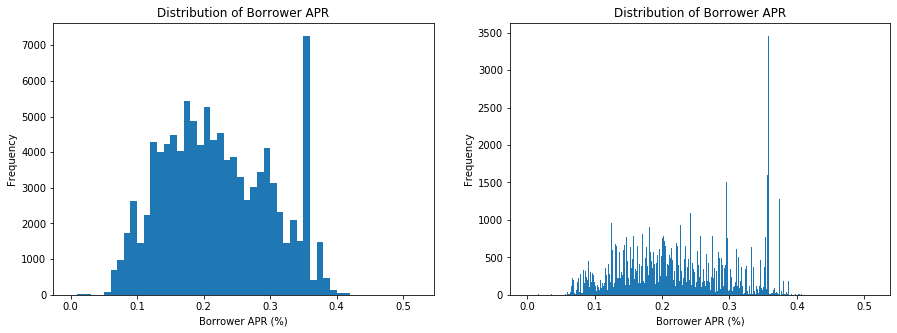

In [46]:
plt.figure(figsize = [15, 5]) 

plt.subplot(1, 2, 1) 
bins = np.arange(0, loan.BorrowerAPR.max()+0.01, 0.01)
plt.hist(data = loan, x = 'BorrowerAPR', bins = bins);
plt.xlabel('Borrower APR (%)')
plt.title('Distribution of Borrower APR')
plt.ylabel('Frequency');

plt.subplot(1, 2, 2)
bins = np.arange(0, loan.BorrowerAPR.max()+0.001, 0.001)
plt.hist(data = loan, x = 'BorrowerAPR', bins = bins);
plt.xlabel('Borrower APR (%)')
plt.title('Distribution of Borrower APR')
plt.ylabel('Frequency');

The distribution of Borrower APR has a peak around 0.35. The distribution was plotted using two different bin sizes to understand the distribution better. Looking at the numeric values in the dataframe it appears that the APR for the loan has 5 digits of significance.

Next, I'll explore the distribution of BorrowerRate to see if it is similar to the Borrower APR

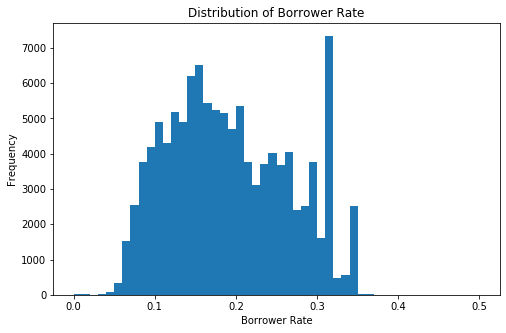

In [24]:
bins = np.arange(0, loan.BorrowerRate.max()+0.01, 0.01)
plt.figure(figsize=[8, 5])
plt.hist(data = loan, x = 'BorrowerRate', bins = bins);
plt.xlabel('Borrower Rate')
plt.title('Distribution of Borrower Rate')
plt.ylabel('Frequency');

The interest rate (Borrower rate) is slighter lower than the APR. As the variables are highly correlated and have a similar meaning, I will analyze only the Borrower APR.

[This](https://www.consumerfinance.gov/ask-cfpb/what-is-the-difference-between-a-mortgage-interest-rate-and-an-apr-en-135/#:~:text=The%20interest%20rate%20is%20the,to%20pay%20for%20the%20loan.&text=The%20APR%20reflects%20the%20interest,pay%20to%20get%20the%20loan.) link describes the difference between interest rate and APR. Interest does not reflect fees or any other charges you may have to pay for the loan. The APR reflects the interest rate, any points, mortgage broker fees, and other charges that you pay to get the loan.

Next, I'll explore the distribuion of borrowers in the dataset based on Prosper Score and Prosper Rating.

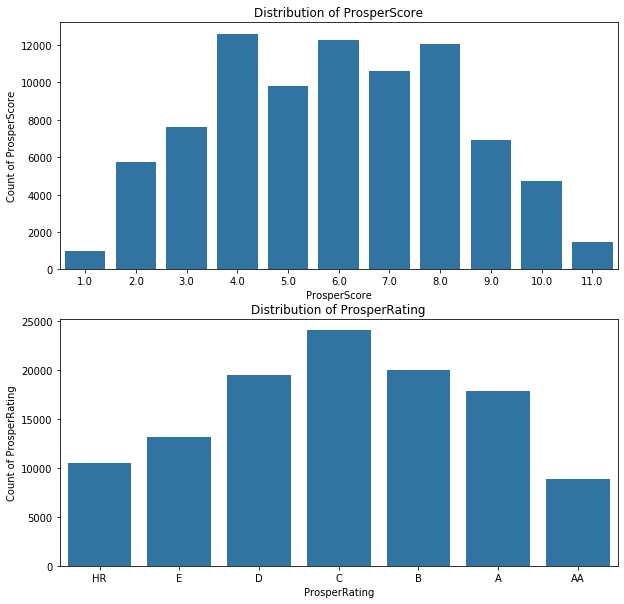

In [25]:
# Plot a standard-scaled plot for ProsperScore and ProsperRating
fig, ax = plt.subplots(nrows=2, figsize = [10,10])

variables = ['ProsperScore', 'ProsperRating']

for i in range(len(variables)):
    var = variables[i]
    sb.countplot(data = loan, x = var, ax = ax[i], color = sb.color_palette()[0]).set_title(f'Distribution of {var}')
    ax[i].set(xlabel=f"{var}", ylabel = f"Count of {var}")
plt.show()

The bar charts show that most borrowers who apply for Prosper loan have average ratings.

The next variable I wish to explore is Debt to Income Ratio.

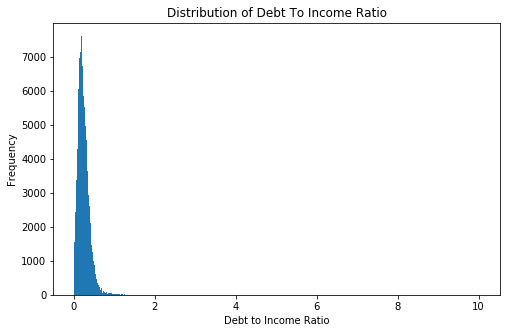

In [26]:
# Plot a standard-scaled plot for DebtToIncomeRatio
binsize = 0.02
bins = np.arange(0, loan['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan[loan['DebtToIncomeRatio'].notnull()],\
                 x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.title('Distribution of Debt To Income Ratio')
plt.ylabel('Frequency');

The distribution has outliers and is right-skewed. Setting limits on x-axis to take a closer look at the plot

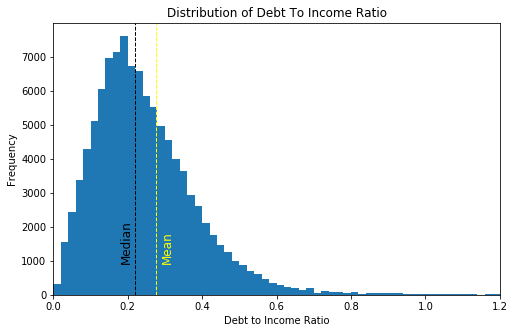

In [27]:
binsize = 0.02
bins = np.arange(0, loan['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan[loan['DebtToIncomeRatio'].notnull()],\
                 x = 'DebtToIncomeRatio', bins = bins)
plt.axvline(loan['DebtToIncomeRatio'].mean(), color='yellow', linestyle='dashed', linewidth=1)
plt.annotate('Mean', xy=(0.29,1000), rotation=90, color='yellow', fontsize=12)
plt.axvline(loan['DebtToIncomeRatio'].median(), color='k', linestyle='dashed', linewidth=1)
plt.annotate('Median', xy=(0.18,1000), rotation=90, color='k', fontsize=12)
plt.xlabel('Debt to Income Ratio')
plt.title('Distribution of Debt To Income Ratio')
plt.ylabel('Frequency')
plt.xlim(0,1.2);

The distribution is unimodal. Next, I'll look at the Loan Amount.

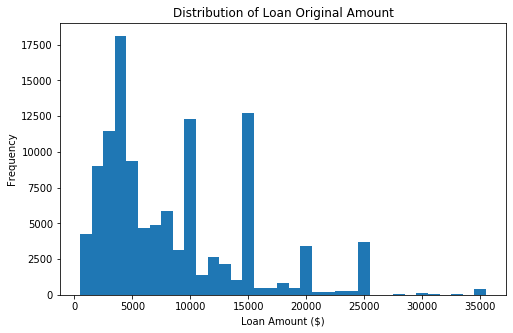

In [28]:
# Distribution for LoanOriginalAmount
binsize = 1000
bins = np.arange(500, loan['LoanOriginalAmount'].max()+binsize+500, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.title('Distribution of Loan Original Amount')
plt.ylabel('Frequency');

Most popular loan amount is USD 4000. Loan amounts in the multiples of 5000 are more popular (e.g. 10000, 15000)

Lastly, I explored the distribution of Stated Monthly Income using a box plot and histogram.

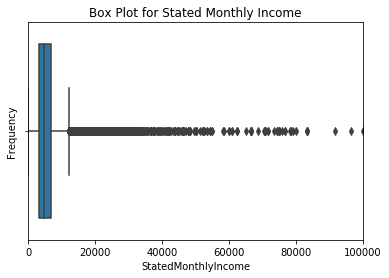

In [29]:
# Box Plot for StatedMonthlyIncome
sb.boxplot(data=loan, x='StatedMonthlyIncome');
plt.xlim(0,100000)
plt.title('Box Plot for Stated Monthly Income')
plt.ylabel('Frequency');

Month Income data has outliers. The max value for StatedMonthlyIncome in the dataset is 1750000. Limit on the x-axis crops off this value from the chart. There are many other high values in this column. Such high values of monthly income seem incorrect. There could be some cases where annual income was reported as monthly income. Removing the monthly income values > 10000. These rows are less than 1% of the total dataset. So, we can remove them.

In [30]:
mask = loan['StatedMonthlyIncome']>10000
outliers = loan[mask]['ListingCreationDate'].count()
total = loan.shape[0]
print(outliers, total, outliers/total)

9780 113937 0.08583690987124463


In [31]:
# Removing outliers (i.e, keeping only monthly income <= 10000)
loan = loan.loc[loan['StatedMonthlyIncome']<=10000]

In [32]:
# Test the code
loan.shape

(104157, 15)

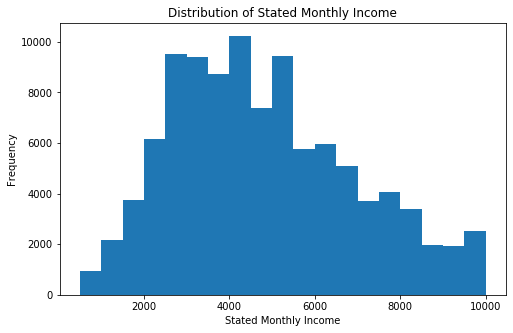

In [33]:
# Distribution for Stated Monthly Income
binsize = 500
bins = np.arange(500, loan['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income')
plt.ylabel('# of Borrowers')
plt.title('Distribution of Stated Monthly Income')
plt.ylabel('Frequency');

Stated Monthly Income is right-skewed.

### Distribution of the variable of interest

> Borrower APR has a mode value around 0.35. The debt to income ratio has outliers and a limit on x-axis was set to view the right skewed plot clearly.

### Unusual distributions in the features that were investigated

> It was interesting to note that the loan amount is borrowed in the multiples of USD 5000.
For the Stated Monthly Income, top 1% of the values were outliers. These were removed from the dataset.

>Two of the variable Credit Grade and Prosper Ratings were diffent variable names of rating system. The changes were made in 2009. The two variables have been combined for this analysis.

> _Prosper 1.0 was from their beginning in 2006 to 2008 when underwriting standards were very lax (the minimum credit score was 520) and investor returns, on average, were negative. Prosper 2.0 is from 2009 to the present day when underwriting standards improved dramatically (minimum FICO score is now 640) and returns for investors have been much better._ [Source](https://www.lendacademy.com/prosper-review/)